# Using Deep-Q Reinforcement Learning to To Train a Mrs. Pacman AI Using Deep Q Network
### Credit to Adrian Yijie Xu.
### Customization by Ivan Hammel, Hunter Harris, Kevin Scott, Lyle Tingle, William Lyons

###### Implementation in Tensorflow 1.x
###### Original Code:
https://github.com/EXJUSTICE/Deep_Q-learning_OpenAI_MissPacman.
###### Original Model's Explanation: 
https://towardsdatascience.com/automating-pac-man-with-deep-q-learning-an-implementation-in-tensorflow-ca08e9891d9c

## Training

### Libraries

First we import all the necessary libraries </font> 


In [ ]:
%tensorflow_version 1.x

In [ ]:
import gym
import random
import numpy as np
import tensorflow as tf
from datetime import datetime
import matplotlib.pyplot as plt
from collections import deque, Counter
from tensorflow.contrib.layers import flatten, conv2d, fully_connected
print(tf.__version__)

1.15.2


Check if GPU is available and can be used

In [ ]:
GPU = True
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
  GPU = False
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### Preprocessing
* By cropping the image and changing the colours to enhance Ms. Pacman's contrast the inputs will look more distinct to the model
* This makes it easier for the model to associate state-rewards-action pairings

In [ ]:
# Choose Ms. Pacman color to enchance contrast of Ms. Pacman vs rest of ghosts/game
color = np.array([210, 164, 74]).mean()

def preprocess_observation(obs):

    # Crop and resize the image
    img = obs[1:172:2, ::2]

    # Convert the image to greyscale
    img = img.mean(axis=2)

    # Improve image contrast
    img[img==color] = 0

    # Next we normalize the image from -1 to +1
    img = (img - 128) / 128 - 1

    return img.reshape(86,80,1)


### Preprocessing Display
*   Here we initialize the OpenAIGym MsPacman Atari 2600 environment and list the possible actions.
*   Afterwards we display the input screen before, druing and after processing



9
['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']


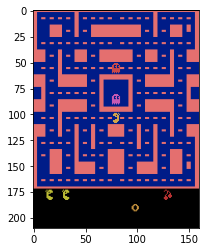

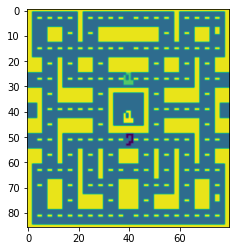

(210, 160, 3)
(86, 80)


In [ ]:
# Create environment and list possible actions
env = gym.make("MsPacman-v0")
n_outputs = env.action_space.n
print(n_outputs)
print(env.env.get_action_meanings())

# Create and show input, before and after pre-processing
observation = env.reset()
plt.imshow(observation)
plt.show()

obs_preprocessed = preprocess_observation(observation).reshape(86,80)
plt.imshow(obs_preprocessed)
plt.show()
print(observation.shape)
print(obs_preprocessed.shape)

# Deep-Q Neural Network
* The Deep-Q NN is built as a function called q_network
* q_network has three convolutional layers, each with decreasing kernel and strides, with appropriate padding to ensure dimensions are kept ('padding=SAME').
* Afterwards the matrix is flattened and fed into two fully connected layers.
* The first fully connected layer uses a ReLU activation (default)
* The last does not apply an activation function in order to output display 

In [ ]:
tf.compat.v1.reset_default_graph()
#Reset is technically not necessary if variables done  in TF2
#https://github.com/ageron/tf2_course/issues/8

def q_network(X, name_scope):
    
    # Initialize layers
    initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=2.0, distribution='normal')
    if (GPU): processing_device = '/device:GPU:0'
    else: processing_device = '/cpu:0'

    with tf.device(processing_device):
      with tf.compat.v1.variable_scope(name_scope) as scope: 
          # initialize the convolutional layers
          layer_1 = conv2d(X, num_outputs=32, kernel_size=(8,8), stride=4, padding='SAME', weights_initializer=initializer) 
          layer_2 = conv2d(layer_1, num_outputs=64, kernel_size=(4,4), stride=2, padding='SAME', weights_initializer=initializer)
          layer_3 = conv2d(layer_2, num_outputs=64, kernel_size=(3,3), stride=1, padding='SAME', weights_initializer=initializer)
          
          # Flatten the result of layer_3 before feeding to the fully connected layer
          flat = flatten(layer_3)
          # Insert fully connected layer
          fc = fully_connected(flat, num_outputs=128, weights_initializer=initializer)

          #Add final output layer
          output = fully_connected(fc, num_outputs=n_outputs, activation_fn=None, weights_initializer=initializer) 

          # Vars will store the parameters of the network such as weights
          vars = {v.name[len(scope.name):]: v for v in tf.compat.v1.get_collection(key=tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, scope=scope.name)} 
          #Return both variables and outputs together
          return vars, output

### Epsilon_greedy function.

* Selects the best action (probability p = [1 - epsilon]) or it selects a random action ( probability [epsilon] ).
* This random aspects prevents overtraining and inescapable loops, as it forces the model to take actions that may be short term sub-optimal, but ong term optimal.
* As time passes the model is more likely to have explored all paths and therefore the optimal choice is more likely to be correct, hence exploring is less important and epsilon can be decreased to 5%

In [ ]:
# Explora a lot > 50% at the beginning and a little <5% at the end
epsilon = 0.60
eps_min = 0.05
eps_max = 1.00
eps_decay_steps = 500000

def epsilon_greedy(action, step):
    p = np.random.random(1).squeeze() #1D entries returned using squeeze
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps) #Decaying policy with more steps
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        return action

### Buffer
* Stores gameplay information in SARSA (state–action–reward–state–action).
* Uses this information for Deep-Q
We store all the agent's experience i.e (state, action, rewards) in the experience replay buffer
and  we sample from this minibatch of experience for generating the y-values for the update function, and hence train the network.
* Since experiences matter less the farther away they are the entire game does not need to be stored, 2000 is sufficient until the next state-action-reward pair is so far in the future or past as to be irrelevant



In [ ]:
buffer_len = 20000
#Buffer is made from a deque - double ended queue
exp_buffer = deque(maxlen=buffer_len)

Next, we define a function called sample_memories for sampling experiences from the memory according to batches. Batch size is the number of experience sampled
from the memory.


In [ ]:
def sample_memories(batch_size):
    perm_batch = np.random.permutation(len(exp_buffer))[:batch_size]
    mem = np.array(exp_buffer)[perm_batch]
    return mem[:,0], mem[:,1], mem[:,2], mem[:,3], mem[:,4]


### Hyperparamaters
* num_episodes = Number of episodes to train for
* batch_size = number of experience sampled from the memory
* input_shape = X_shape = ( # of images, y, x, channels )
* learning_rate = rate of change of parameters as discussed in class
* discount_factor = propagating discount of future rewards


* global_step = running counter of how many moves taken
* copy_steps = amount of steps befor copying training network weights to data generating network
* steps_train = Period after which model is updated with new data


* NO_SCORE_LIMIT = Number of frames without getting any points before points are deducted
* TIME_LIMIT = Number of frames in a fast play of level 1; if passed, points are deducted
* FRAMES_PER_POINT = Number of frames that pass before 10 points are deducted

In [ ]:
num_episodes = 400
batch_size = 48
input_shape = (None, 86, 80, 1)
learning_rate = 0.005
X_shape = (None, 86, 80, 1)
discount_factor = 0.97

global_step = 0
copy_steps = 100
steps_train = 4
start_steps = 2000

# Custom Scoring Parameters
NO_SCORE_LIMIT = 87 
TIME_LIMIT = 2900
FRAMES_PER_POINT = 60

In [ ]:
# Now we define the placeholder for our input i.e game state
X = tf.compat.v1.placeholder(tf.float32, shape=X_shape)

# we define a boolean called in_training_mode to toggle the training
in_training_mode = tf.compat.v1.placeholder(tf.bool)

### Q Networks
* We build two Q networks, primary and target.
* This allows training and data generation to occur concurrently.
* That is why the network returns the network outputs and the network weights. 

In [ ]:
# we build our Q network, which takes the input X and generates Q values for all the actions in the state
mainQ, mainQ_outputs = q_network(X, 'mainQ')

# similarly we build our target Q network
targetQ, targetQ_outputs = q_network(X, 'targetQ')


In [ ]:
# define the placeholder for our action values

X_action = tf.compat.v1.placeholder(tf.int32, shape=(None,))
Q_action = tf.reduce_sum(input_tensor=targetQ_outputs * tf.one_hot(X_action, n_outputs), axis=-1, keepdims=True)


Copy the primary Q network parameters to the target  Q network

In [ ]:

copy_op = [tf.compat.v1.assign(main_name, targetQ[var_name]) for var_name, main_name in mainQ.items()]
copy_target_to_main = tf.group(*copy_op)


Compute and optimize loss using gradient descent optimizer


In [ ]:
# define a placeholder for our output i.e action
y = tf.compat.v1.placeholder(tf.float32, shape=(None,1))

# now we calculate the loss which is the difference between actual value and predicted value
loss = tf.reduce_mean(input_tensor=tf.square(y - Q_action))

# we use adam optimizer for minimizing the loss
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.compat.v1.global_variables_initializer()

loss_summary = tf.compat.v1.summary.scalar('LOSS', loss)


### Training Loop

1. Preprocess game screen / state s
2. Feed and s into Deep-Q NN
3. Select action a using Q values of all possible actions and epsilon-greedy policy
4. Perform action a state s which moves model to new state s' with reward r
5. Store <s,a,r,s'> in buffer [ up to 2000 sequences ]
6. Sample random batches of <s,a,r,s'> sequences to calculate the loss [ 48 batches ]
7. Optimize network parameters to minimize loss [ every 4 steps ]
8. Copy network weight from target to data generating [ every C steps ]
6. Loop 1-5 M times

\* Loss = squared difference between target and predicted Q).

\* Epochs here exist since the data is analyzed in batches.

In [ ]:
with tf.compat.v1.Session() as sess:
    init.run()
    
    # for each episode
    history = []
    for i in range(num_episodes):
        done = False
        obs = env.reset()
        epoch = 0
        episodic_reward = 0
        game_score = 0
        actions_counter = Counter() 
        episodic_loss = []

        frame = 0
        lastTimeScored = 0
        lastTimeDeducted = 0

        # while the game is not over
        while not done:
            # get the preprocessed game screen
            obs = preprocess_observation(obs)

            # feed the game screen and get the Q values for each action,  FEED THE NETWORK BY CALLING THE OUTPUT LAYER
            actions = mainQ_outputs.eval(feed_dict={X:[obs], in_training_mode:False})

            # get the action
            action = np.argmax(actions, axis=-1)
            actions_counter[str(action)] += 1 

            # select the action using epsilon greedy policy
            action = epsilon_greedy(action, global_step)

            # now perform the action and move to the next state, next_obs, receive reward
            next_obs, reward, done, _ = env.step(action)

            # Store this transistion as an experience in the replay buffer! Quite important
            exp_buffer.append([obs, action, preprocess_observation(next_obs), reward, done])
            
            # After certain steps, we train our Q network with samples from the experience replay buffer
            if global_step % steps_train == 0 and global_step > start_steps:
                
                # sample experience, mem[:,0], mem[:,1], mem[:,2], mem[:,3], mem[:,4]
                o_obs, o_act, o_next_obs, o_rew, o_done = sample_memories(batch_size)

                # states
                o_obs = [x for x in o_obs]

                # next states
                o_next_obs = [x for x in o_next_obs]

                # next actions
                next_act = mainQ_outputs.eval(feed_dict={X:o_next_obs, in_training_mode:False})


                # discounted reward: these are our Y-values
                y_batch = o_rew + discount_factor * np.max(next_act, axis=-1) * (1-o_done) 

                # To calculate the loss, we run the previously defined functions mentioned while feeding inputs
                train_loss, _ = sess.run([loss, training_op], feed_dict={X:o_obs, y:np.expand_dims(y_batch, axis=-1), X_action:o_act, in_training_mode:True})
                episodic_loss.append(train_loss)
            
            # after some interval we copy our main Q network weights to target Q network
            if (global_step+1) % copy_steps == 0 and global_step > start_steps:
                copy_target_to_main.run()
                
            obs = next_obs
            epoch += 1
            global_step += 1
            game_score += reward
            # Custom Reward Scoring:
            if reward > 0:
                lastTimeScored = frame
                episodic_reward += reward
            else:
                if frame - lastTimeScored >= NO_SCORE_LIMIT:
                    if frame - lastTimeDeducted >= FRAMES_PER_POINT:
                        lastTimeDeducted = frame
                        episodic_reward -= 10
            if frame > TIME_LIMIT:
                if frame - lastTimeDeducted >= FRAMES_PER_POINT:
                    lastTimeDeducted = frame
                    episodic_reward -= 10
            frame += 1
        
        history.append(episodic_reward)
        print('EPISODE NUMBER: {} || EPOCHS/EPISODE: {} || CLASSIC SCORE: {} || CUSTOM SCORE: {}'.format(len(history), epoch, game_score, episodic_reward))
    



EPISODE NUMBER: 1 || EPOCHS/EPISODE: 561 || CLASSIC SCORE: 200.0 || CUSTOM SCORE: 170.0
EPISODE NUMBER: 2 || EPOCHS/EPISODE: 701 || CLASSIC SCORE: 290.0 || CUSTOM SCORE: 260.0
EPISODE NUMBER: 3 || EPOCHS/EPISODE: 564 || CLASSIC SCORE: 140.0 || CUSTOM SCORE: 110.0
EPISODE NUMBER: 4 || EPOCHS/EPISODE: 558 || CLASSIC SCORE: 200.0 || CUSTOM SCORE: 180.0
EPISODE NUMBER: 5 || EPOCHS/EPISODE: 737 || CLASSIC SCORE: 270.0 || CUSTOM SCORE: 240.0
EPISODE NUMBER: 6 || EPOCHS/EPISODE: 630 || CLASSIC SCORE: 320.0 || CUSTOM SCORE: 310.0
EPISODE NUMBER: 7 || EPOCHS/EPISODE: 625 || CLASSIC SCORE: 180.0 || CUSTOM SCORE: 130.0
EPISODE NUMBER: 8 || EPOCHS/EPISODE: 563 || CLASSIC SCORE: 210.0 || CUSTOM SCORE: 190.0
EPISODE NUMBER: 9 || EPOCHS/EPISODE: 521 || CLASSIC SCORE: 180.0 || CUSTOM SCORE: 170.0
EPISODE NUMBER: 10 || EPOCHS/EPISODE: 708 || CLASSIC SCORE: 190.0 || CUSTOM SCORE: 140.0
EPISODE NUMBER: 11 || EPOCHS/EPISODE: 644 || CLASSIC SCORE: 140.0 || CUSTOM SCORE: 90.0
EPISODE NUMBER: 12 || EPOCHS/EP

KeyboardInterrupt: ignored

Let's plot our reward distribution across the incremental episodes. Remember to interrupt the training process first.

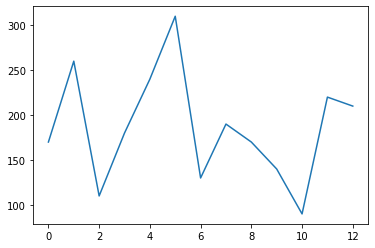

In [ ]:
plt.plot(history)
plt.show()

## Evaluation

Now that the model is trained we can have it play a game using OpenAIGym's environment and calculate the loss to analyze it's performance

In [ ]:
# Dependencies first for graphics visualization within Colaboratory

#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1



In [ ]:
#Use Ipython display to record video
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only

import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay


from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [ ]:
#Evaluate model on openAi GYM
env = wrap_env(gym.make('MsPacman-v0'))
observation = env.reset()
new_observation = observation

prev_input = None
done = False

with tf.compat.v1.Session() as sess:
    # For custom scoring.
    frame = 0
    lastTimeScored = 0
    lastTimeDeducted = 0
    game_score = 0
    custom_score = 0

    init.run()
    while True:
      if True: 
    
        #set input to network to be difference image
        obs = preprocess_observation(observation)

        # feed the game screen and get the Q values for each action
        actions = mainQ_outputs.eval(feed_dict={X:[obs], in_training_mode:False})

        # get the action
        action = np.argmax(actions, axis=-1)
        actions_counter[str(action)] += 1 

        # select the action using epsilon greedy policy
        action = epsilon_greedy(action, global_step)
        env.render()
        observation = new_observation        
        # now perform the action and move to the next state, next_obs, receive reward
        new_observation, reward, done, _ = env.step(action)
        
        # scoring
        game_score = game_score + reward
        if reward > 0:
                lastTimeScored = frame
                custom_score += reward
            else:
                if frame - lastTimeScored >= NO_SCORE_LIMIT:
                    if frame - lastTimeDeducted >= FRAMES_PER_POINT:
                        lastTimeDeducted = frame
                        custom_score -= 10
            if frame > TIME_LIMIT:
                if frame - lastTimeDeducted >= FRAMES_PER_POINT:
                    lastTimeDeducted = frame
                    custom_score -= 10
        frame += 1

        if done: 
          #observation = env.reset()
          break
      
    env.close()
    show_video()
    print("Custom Score:", custom_score, "Game Score:", game_score)